## nav_msgs/Odometry Message

```yaml
std_msgs/Header header
string child_frame_id
geometry_msgs/PoseWithCovariance pose
geometry_msgs/TwistWithCovariance twist
```



## geometry_msgs/PointStamped

```yaml
std_msgs/Header header
geometry_msgs/Point point
```

# Versuch PRIOR

<IPython.core.display.Javascript object>


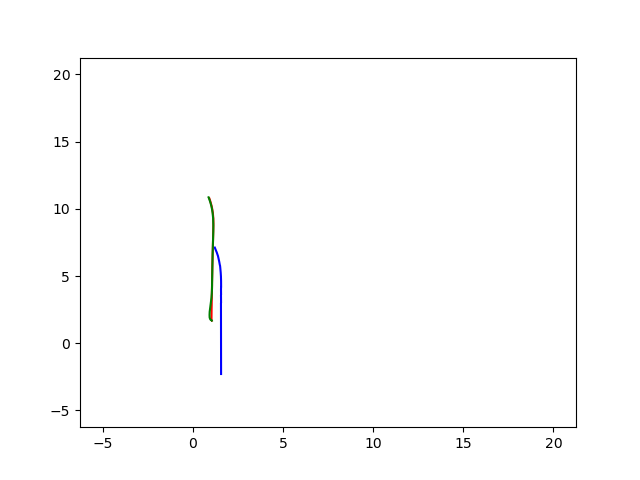

--- Tachy measurement is in ----
x_state :  [[1.0573338284 1.6803398737 0.01         1.57        ]]
delta_t
0.0001
v_mean was nan
v_mean
0
delta_a was nan
delta_a
1e-05
old_tachy_seq
914
old_tachy_time
1647967369.8118775
R_ was too low
R_
0.001
x_state_ :  [[1.0573338284 1.6803398837 0.           1.57001     ]]
ox1_vk
7.863267138642299e-08
ox1_ypsk
-9.999996869033565e-09
oy1_vk
9.999996908451018e-05
oy1_ypsk
7.913267046841255e-12
oyps_vk
0.1
P
[[0.01 0.   0.   0.  ]
 [0.   0.01 0.   0.  ]
 [0.   0.   0.01 0.  ]
 [0.   0.   0.   0.01]]
F
[[ 1.            0.            0.0000000786 -0.00000001  ]
 [ 0.            1.            0.0001        0.          ]
 [ 0.            0.            1.            0.          ]
 [ 0.            0.            0.1           1.          ]]
FtF
[[ 1.            0.            0.0000000786 -0.0000000021]
 [ 0.            1.00000001    0.0001        0.00001     ]
 [ 0.0000000786  0.0001        1.            0.1         ]
 [-0.0000000021  0.00001       0.1     

/tmp/ipykernel_26158/3562214938.py:158: RuntimeWarning: Mean of empty slice
  v_mean = np.nanmean(twist.twist_[:,0],axis=0)       # From Odometry: mean linear Twist
/tmp/ipykernel_26158/3562214938.py:166: RuntimeWarning: Mean of empty slice
  delta_a = np.nanmean(twist.twist_[:,5],axis=0) * delta_t   # From Odometry: cummulative rotation Twist


--1
(11, 3)
(3, 3)
(3, 4)
--2
(11, 3)
(3, 3)
(3, 4)
--end
--- Tachy measurement is in ----
x_state :  [[ 1.0417661998  1.7305199192 -0.0003268658 29.4009924075]]
delta_t
0.14797067642211914
v_mean was nan
v_mean
0
delta_a was nan
delta_a
1e-05
old_tachy_seq
916
old_tachy_time
1647967370.1080074
R_ was too low
R_
0.001
x_state_ :  [[ 1.0417661955  1.7305199101  0.           29.4010024075]]
ox1_vk
-0.06357862876702954
ox1_ypsk
9.029836182982472e-09
oy1_vk
-0.13361541469801952
oy1_ypsk
-4.296749759919068e-09
oyps_vk
147.97067642211914
P
[[ 0.0011145081  0.0000079372 -0.0001022265 -0.0154887235]
 [ 0.0000079372  0.0011302714 -0.0002455776 -0.0372083706]
 [-0.0001022265 -0.0002455776  0.0033777032  0.4792237691]
 [-0.0154887235 -0.0372083706  0.4792237691 72.6192000538]]
F
[[  1.             0.            -0.0635786288   0.000000009 ]
 [  0.             1.            -0.1336154147  -0.0000000043]
 [  0.             0.             1.             0.          ]
 [  0.             0.           

--- Tachy measurement is in ----
x_state :  [[ 1.0405618716  1.7323804608 -0.0000901664 29.1856784132]]
delta_t
0.14772295951843262
v_mean was nan
v_mean
0
delta_a was nan
delta_a
1e-05
old_tachy_seq
920
old_tachy_time
1647967370.7078247
R_ was too low
R_
0.001
x_state_ :  [[ 1.0405618654  1.7323804529  0.           29.1856884132]]
ox1_vk
-0.09050627938023902
ox1_ypsk
7.903312893345858e-09
oy1_vk
-0.11675052959892988
oy1_ypsk
-6.126797311893986e-09
oyps_vk
147.72295951843262
P
[[  0.0004437682   0.0000763285  -0.0002291093  -0.1651050896]
 [  0.0000763285   0.0005354213  -0.0003997379  -0.2931529861]
 [ -0.0002291093  -0.0003997379   0.001549151    0.8400263797]
 [ -0.1651050896  -0.2931529861   0.8400263797 646.4730716833]]
F
[[  1.             0.            -0.0905062794   0.0000000079]
 [  0.             1.            -0.1167505296  -0.0000000061]
 [  0.             0.             1.             0.          ]
 [  0.             0.           147.7229595184   1.          ]]
FtF
[[    

(10, 3)
(10, 4)
--2
(64, 3)
(10, 3)
(10, 4)
--end
--- Tachy measurement is in ----
x_state :  [[ 1.0403665847  1.7327460216 -0.0000330498 29.0616930327]]
delta_t
0.1560049057006836
v_mean was nan
v_mean
0
delta_a was nan
delta_a
1e-05
old_tachy_seq
923
old_tachy_time
1647967371.1646028
R_ was too low
R_
0.001
x_state_ :  [[ 1.0403665777  1.7327460145  0.           29.0617030327]]
ox1_vk
-0.11009448882137614
ox1_ypsk
7.084955764864037e-09
oy1_vk
-0.11052933607798006
oy1_ypsk
-7.057152527720906e-09
oyps_vk
156.0049057006836
P
[[  0.0003579371   0.0001193331  -0.0002650668  -0.2704845117]
 [  0.0001193331   0.0004363757  -0.000351269   -0.3811133294]
 [ -0.0002650668  -0.000351269    0.0012158114   0.7440025586]
 [ -0.2704845117  -0.3811133294   0.7440025586 914.1738652217]]
F
[[  1.             0.            -0.1100944888   0.0000000071]
 [  0.             1.            -0.1105293361  -0.0000000071]
 [  0.             0.             1.             0.          ]
 [  0.             0.     

--- Tachy measurement is in ----
x_state :  [[ 1.0402085674  1.7328558865  0.0000450979 29.1331159571]]
delta_t
0.15203857421875
v_mean was nan
v_mean
0
delta_a was nan
delta_a
1e-05
old_tachy_seq
926
old_tachy_time
1647967371.6121986
R_ was too low
R_
0.001
x_state_ :  [[ 1.0402085609  1.732855879   0.           29.1331259571]]
ox1_vk
-0.099334768741119
ox1_ypsk
7.570506477564895e-09
oy1_vk
-0.11510139777439177
oy1_ypsk
-6.533561943203314e-09
oyps_vk
152.03857421875
P
[[   0.0003294489    0.0001463633   -0.0002765396   -0.331012032 ]
 [   0.0001463633    0.0003797135   -0.0003130027   -0.4070806719]
 [  -0.0002765396   -0.0003130027    0.0011075826    0.6224278534]
 [  -0.331012032    -0.4070806719    0.6224278534 1031.6704769106]]
F
[[  1.             0.            -0.0993347687   0.0000000076]
 [  0.             1.            -0.1151013978  -0.0000000065]
 [  0.             0.             1.             0.          ]
 [  0.             0.           152.0385742188   1.          ]]
Ft

--- Tachy measurement is in ----
x_state :  [[ 1.040171079   1.732985766  -0.0000090306 29.0484789694]]
delta_t
0.1473684310913086
v_mean
0.0
delta_a too small
delta_a
1e-05
old_tachy_seq
929
old_tachy_time
1647967372.059854
R_ was too low
R_
0.001
x_state_ :  [[ 1.0401710718  1.732985759   0.           29.0484889694]]
ox1_vk
-0.10537019342681528
ox1_ypsk
6.9910862701130436e-09
oy1_vk
-0.10302706838258238
oy1_ypsk
-7.1501547364112225e-09
oyps_vk
147.3684310913086
P
[[   0.0003109267    0.0001628092   -0.0002758172   -0.3489904   ]
 [   0.0001628092    0.0003492121   -0.0002976266   -0.4091255012]
 [  -0.0002758172   -0.0002976266    0.0010763619    0.5256841576]
 [  -0.3489904      -0.4091255012    0.5256841576 1057.7880260699]]
F
[[  1.             0.            -0.1053701934   0.000000007 ]
 [  0.             1.            -0.1030270684  -0.0000000072]
 [  0.             0.             1.             0.          ]
 [  0.             0.           147.3684310913   1.          ]]
FtF
[[

--1
(134, 3)
(19, 3)
(19, 4)
--2
(134, 3)
(19, 3)
(19, 4)
--end
--- Tachy measurement is in ----
x_state :  [[ 1.0400851762  1.7330045796  0.0001090415 29.0983543142]]
delta_t
0.16768574714660645
v_mean
0.0
delta_a too small
delta_a
1e-05
old_tachy_seq
932
old_tachy_time
1647967372.5278952
R_ was too low
R_
0.001
x_state_ :  [[ 1.0400851694  1.7330045722  0.           29.0983643142]]
ox1_vk
-0.11390370306693634
ox1_ypsk
7.3388613347187895e-09
oy1_vk
-0.12306281413877562
oy1_ypsk
-6.792725101259674e-09
oyps_vk
167.68574714660645
P
[[   0.0003011856    0.0001732678   -0.0002775876   -0.3507804022]
 [   0.0001732678    0.0003250475   -0.0002871024   -0.394201823 ]
 [  -0.0002775876   -0.0002871024    0.0010614177    0.4601655073]
 [  -0.3507804022   -0.394201823     0.4601655073 1040.7920636191]]
F
[[  1.             0.            -0.1139037031   0.0000000073]
 [  0.             1.            -0.1230628141  -0.0000000068]
 [  0.             0.             1.             0.          ]
 [  

--1
(155, 3)
(22, 3)
(22, 4)
--2
(155, 3)
(22, 3)
(22, 4)
--end
--- Tachy measurement is in ----
x_state :  [[ 1.0399141139  1.7329380518  0.0015849856 28.9954820949]]
delta_t
0.1480560302734375
v_mean
0.03443045442303022
delta_a too small
delta_a
1e-05
old_tachy_seq
935
old_tachy_time
1647967372.9602165
R_
509.7636402384372
x_state_ :  [[ 1.0360855605  1.7295723312  0.0344304544 28.9954920949]]
ox1_vk
-0.1111962256400034
ox1_ypsk
0.0033657206798807238
oy1_vk
-0.09775473136245884
oy1_ypsk
-0.003828553407402069
oyps_vk
0.0002904405465328709
P
[[  0.0002035549   0.0001341082  -0.0002091675  -0.1195491559]
 [  0.0001341082   0.0004526145  -0.000340319   -0.4807509468]
 [ -0.0002091675  -0.000340319    0.0010582596   0.2860879443]
 [ -0.1195491559  -0.4807509468   0.2860879443 881.8545391381]]
F
[[ 1.            0.           -0.1111962256  0.0033657207]
 [ 0.            1.           -0.0977547314 -0.0038285534]
 [ 0.            0.            1.            0.          ]
 [ 0.            0. 

K
[[ 0.2850358234 -0.1735830312 -0.0346995259]
 [-0.1735830312  0.4417963488 -0.0217853377]
 [-0.1387981037 -0.0871413509  0.1057619634]
 [ 6.1140087038 -9.0929662139 -0.0326064405]]
y
[[ 0.0334153517]
 [ 0.0304221211]
 [-0.0615846678]]
x_state_
[[ 1.0065234564  1.7195690753  0.0972744723 28.7515250724]]
K*y
[[ 0.0063807671]
 [ 0.0089816868]
 [-0.0138023276]
 [-0.070317511 ]]
x_state_update
[[ 1.0129042235]
 [ 1.7285507621]
 [ 0.0834721448]
 [28.6812075614]]
P
[[ 0.0007125896 -0.0004339576 -0.0003469953  0.0152850218]
 [-0.0004339576  0.0011044909 -0.0002178534 -0.0227324155]
 [-0.0003469953 -0.0002178534  0.0010576196 -0.0003260644]
 [ 0.0152850218 -0.0227324155 -0.0003260644  0.5848292756]]
x_state_estimate :  [[ 1.0129042235  1.7285507621  0.0834721448 28.6812075614]]
--1
(184, 3)
(27, 3)
(27, 4)
--2
(184, 3)
(27, 3)
(27, 4)
--end
--1
(191, 3)
(27, 3)
(27, 4)
--2
(191, 3)
(27, 3)
(27, 4)
--end
--1
(191, 3)
(27, 3)
(27, 4)
--2
(191, 3)
(27, 3)
(27, 4)
--end
--- Tachy measurement is i

--1
(219, 3)
(31, 3)
(31, 4)
--2
(219, 3)
(31, 3)
(31, 4)
--end
--1
(221, 3)
(31, 3)
(31, 4)
--2
(221, 3)
(31, 3)
(31, 4)
--end
--1
(223, 3)
(31, 3)
(31, 4)
--2
(223, 3)
(31, 3)
(31, 4)
--end
--- Tachy measurement is in ----
x_state :  [[ 0.9787883262  1.7665926438  0.1319186291 28.3230980859]]
delta_t
0.15581440925598145
v_mean
0.15935138463974
delta_a too small
delta_a
1e-05
old_tachy_seq
944
old_tachy_time
1647967374.3122737
R_
2482.924186176376
x_state_ :  [[ 0.9539886059  1.7653822214  0.1593513846 28.3231080859]]
ox1_vk
-0.15562911075855326
ox1_ypsk
0.0012104224001632247
oy1_vk
-0.0075967108864582016
oy1_ypsk
-0.02479972034099376
oyps_vk
6.275439665998447e-05
P
[[ 0.0005248208 -0.0001582281 -0.0003787979  0.0030076087]
 [-0.0001582281  0.0008719831 -0.0001358432 -0.0072382056]
 [-0.0003787979 -0.0001358432  0.0010386729  0.0002106427]
 [ 0.0030076087 -0.0072382056  0.0002106427  0.0741132054]]
F
[[ 1.            0.           -0.1556291108  0.0012104224]
 [ 0.            1.       

--- Tachy measurement is in ----
x_state :  [[ 0.9514444906  1.8437574784  0.1588814379 28.0206405134]]
delta_t
0.1515648365020752
v_mean
0.1927250683307648
delta_a too small
delta_a
1e-05
old_tachy_seq
948
old_tachy_time
1647967374.91175
R_
2921.0343471403635
x_state_ :  [[ 0.9231690733  1.8510885729  0.1927250683 28.0206505134]]
ox1_vk
-0.14671393889036247
ox1_ypsk
-0.007331094424898765
oy1_vk
0.038038399009103635
oy1_ypsk
-0.028275417241388823
oyps_vk
5.188738593589434e-05
P
[[ 0.0004735479 -0.0000373884 -0.0003967742  0.0004832183]
 [-0.0000373884  0.0006937328 -0.0000317732 -0.0033790867]
 [-0.0003967742 -0.0000317732  0.0010547199  0.0003359954]
 [ 0.0004832183 -0.0033790867  0.0003359954  0.0204399364]]
F
[[ 1.            0.           -0.1467139389 -0.0073310944]
 [ 0.            1.            0.038038399  -0.0282754172]
 [ 0.            0.            1.            0.          ]
 [ 0.            0.            0.0000518874  1.          ]]
FtF
[[ 1.0215787248 -0.0053734736 -0.1467

--1
(289, 3)
(40, 3)
(40, 4)
--2
(289, 3)
(40, 3)
(40, 4)
--end
--1
(291, 3)
(40, 3)
(40, 4)
--2
(291, 3)
(40, 3)
(40, 4)
--end
--1
(291, 3)
(40, 3)
(40, 4)
--2
(291, 3)
(40, 3)
(40, 4)
--end
--- Tachy measurement is in ----
x_state :  [[ 0.9317114292  1.9817061144  0.1961742872 27.6860096162]]
delta_t
0.14768123626708984
v_mean
0.2190727233886719
delta_a too small
delta_a
1e-05
old_tachy_seq
953
old_tachy_time
1647967375.6637423
R_
3235.2930622437266
x_state_ :  [[ 0.904797848   1.9996608148  0.2190727234 27.6860196162]]
ox1_vk
-0.12285267911303356
ox1_ypsk
-0.017954700386781042
oy1_vk
0.0819571032926739
oy1_ypsk
-0.026913581214785154
oyps_vk
4.564694246420773e-05
P
[[ 0.0004695574 -0.0000008344 -0.0003860116 -0.000358439 ]
 [-0.0000008344  0.0005469741  0.000101925  -0.0016643885]
 [-0.0003860116  0.000101925   0.0010713616  0.0002906662]
 [-0.000358439  -0.0016643885  0.0002906662  0.0077451824]]
F
[[ 1.            0.           -0.1228526791 -0.0179547004]
 [ 0.            1.       

--1
(324, 3)
(45, 3)
(45, 4)
--2
(324, 3)
(45, 3)
(45, 4)
--end
--1
(325, 3)
(45, 3)
(45, 4)
--2
(325, 3)
(45, 3)
(45, 4)
--end
--1
(325, 3)
(45, 3)
(45, 4)
--2
(325, 3)
(45, 3)
(45, 4)
--end
--- Tachy measurement is in ----
x_state :  [[ 0.932863318   2.1423804122  0.2227399258 27.4098476828]]
delta_t
0.14802980422973633
v_mean
0.24225864887237547
delta_a too small
delta_a
1e-05
old_tachy_seq
958
old_tachy_time
1647967376.4083745
R_
3586.1500365538172
x_state_ :  [[ 0.9095879532  2.1696623586  0.2422586489 27.4098576828]]
ox1_vk
-0.09607707003608812
ox1_ypsk
-0.027281946474886354
oy1_vk
0.11261447310880907
oy1_ypsk
-0.0232753647642312
oyps_vk
4.1278196037773295e-05
P
[[ 0.0004537885 -0.0000174149 -0.0003305206 -0.0005776646]
 [-0.0000174149  0.0004704782  0.0002181595 -0.0009331243]
 [-0.0003305206  0.0002181595  0.0010628714  0.0002025557]
 [-0.0005776646 -0.0009331243  0.0002025557  0.0046306035]]
F
[[ 1.            0.           -0.09607707   -0.0272819465]
 [ 0.            1.      

--1
(355, 3)
(49, 3)
(49, 4)
--2
(355, 3)
(49, 3)
(49, 4)
--end
--1
(357, 3)
(49, 3)
(49, 4)
--2
(357, 3)
(49, 3)
(49, 4)
--end
--- Tachy measurement is in ----
x_state :  [[ 0.9381879425  2.2897409413  0.2477274843 27.2234646115]]
delta_t
0.1473066806793213
v_mean
0.2647555351257324
delta_a too small
delta_a
1e-05
old_tachy_seq
962
old_tachy_time
1647967377.007967
R_
3900.025907084909
x_state_ :  [[ 0.918811788   2.3235874307  0.2647555351 27.2234746115]]
ox1_vk
-0.07318571717319285
ox1_ypsk
-0.03384648940459556
oy1_vk
0.12784016964399317
oy1_ypsk
-0.019376154480596597
oyps_vk
3.77706928591729e-05
P
[[ 0.0004367343 -0.000029694  -0.0002723894 -0.0006455683]
 [-0.000029694   0.0004582995  0.0002891794 -0.000632257 ]
 [-0.0002723894  0.0002891794  0.001065222   0.0001422954]
 [-0.0006455683 -0.000632257   0.0001422954  0.0037229302]]
F
[[ 1.            0.           -0.0731857172 -0.0338464894]
 [ 0.            1.            0.1278401696 -0.0193761545]
 [ 0.            0.            1.  

--- Tachy measurement is in ----
x_state :  [[ 0.9490230476  2.4510727729  0.2619631975 27.0655727942]]
delta_t
0.14839839935302734
v_mean
0.2752945899963379
delta_a too small
delta_a
1e-05
old_tachy_seq
966
old_tachy_time
1647967377.6124408
R_
4085.327650600447
x_state_ :  [[ 0.9345535135  2.4892777829  0.27529459   27.0655827942]]
ox1_vk
-0.0525608770022051
ox1_ypsk
-0.03820500994970644
oy1_vk
0.13877838138305135
oy1_ypsk
-0.014469534058662248
oyps_vk
3.6324723998873447e-05
P
[[ 0.0004169777 -0.0000344416 -0.0002098817 -0.0006758285]
 [-0.0000344416  0.0004637673  0.0003400493 -0.000436521 ]
 [-0.0002098817  0.0003400493  0.0010704373  0.000100475 ]
 [-0.0006758285 -0.000436521   0.000100475   0.0032956682]]
F
[[ 1.            0.           -0.052560877  -0.0382050099]
 [ 0.            1.            0.1387783814 -0.0144695341]
 [ 0.            0.            1.            0.          ]
 [ 0.            0.            0.0000363247  1.          ]]
FtF
[[ 1.0042222686 -0.0067415047 -0.0525

--1
(422, 3)
(58, 3)
(58, 4)
--2
(422, 3)
(58, 3)
(58, 4)
--end
--1
(427, 3)
(58, 3)
(58, 4)
--2
(427, 3)
(58, 3)
(58, 4)
--end
--- Tachy measurement is in ----
x_state :  [[ 0.9714366425  2.665472991   0.2948450284 26.9079835826]]
delta_t
0.14816784858703613
v_mean
0.3139378070831299
delta_a too small
delta_a
1e-05
old_tachy_seq
971
old_tachy_time
1647967378.3606129
R_
4651.548946563935
x_state_ :  [[ 0.9619926189  2.7110196833  0.3139378071 26.9079935826]]
ox1_vk
-0.030083192037616526
ox1_ypsk
-0.045546692286166035
oy1_vk
0.14508174561859513
oy1_ypsk
-0.009444023604373797
oyps_vk
3.185344286154113e-05
P
[[ 0.0004038678 -0.0000251421 -0.000136323  -0.000705106 ]
 [-0.0000251421  0.0004725364  0.0003738285 -0.0002723639]
 [-0.000136323   0.0003738285  0.0010599895  0.0000679259]
 [-0.000705106  -0.0002723639  0.0000679259  0.0030038073]]
F
[[ 1.            0.           -0.030083192  -0.0455466923]
 [ 0.            1.            0.1450817456 -0.0094440236]
 [ 0.            0.           

--- Tachy measurement is in ----
x_state :  [[ 0.9922002153  2.8522471164  0.341307994  26.815020017 ]]
delta_t
0.14858126640319824
v_mean
0.3455549716949463
delta_a too small
delta_a
1e-05
old_tachy_seq
975
old_tachy_time
1647967378.9604557
R_
5134.299530635644
x_state_ :  [[ 0.9864879657  2.9032713594  0.3455549717 26.815030017 ]]
ox1_vk
-0.016531392280838334
ox1_ypsk
-0.05102424296853769
oy1_vk
0.14765874777755364
oy1_ypsk
-0.005712249670068559
oyps_vk
2.8938955648503694e-05
P
[[ 0.0004099687 -0.0000143618 -0.0000883955 -0.0007259931]
 [-0.0000143618  0.0004791084  0.0003882352 -0.0001760797]
 [-0.0000883955  0.0003882352  0.0010614406  0.000050584 ]
 [-0.0007259931 -0.0001760797  0.000050584   0.0028363741]]
F
[[ 1.            0.           -0.0165313923 -0.051024243 ]
 [ 0.            1.            0.1476587478 -0.0057122497]
 [ 0.            0.            1.            0.          ]
 [ 0.            0.            0.000028939   1.          ]]
FtF
[[ 1.0028767603 -0.0021495415 -0.01

--1
(491, 3)
(66, 3)
(66, 4)
--2
(491, 3)
(66, 3)
(66, 4)
--end
--- Tachy measurement is in ----
x_state :  [[ 1.0131023772  3.082347855   0.338999764  26.7477461091]]
delta_t
0.14385700225830078
v_mean
0.3923952420552572
delta_a too small
delta_a
1e-05
old_tachy_seq
981
old_tachy_time
1647967379.6640308
R_
5644.880322248961
x_state_ :  [[ 1.0106073881  3.138741493   0.3923952421 26.7477561091]]
ox1_vk
-0.00635907579420064
ox1_ypsk
-0.05639363806574238
oy1_vk
0.14371638477845303
oy1_ypsk
-0.0024949891176220262
oyps_vk
2.548450880194872e-05
P
[[ 0.0004810578 -0.0000076258 -0.0000532051 -0.0008086725]
 [-0.0000076258  0.0005594639  0.0004418137 -0.0001009964]
 [-0.0000532051  0.0004418137  0.0013657471  0.0000350571]
 [-0.0008086725 -0.0001009964  0.0000350571  0.003042524 ]]
F
[[ 1.            0.           -0.0063590758 -0.0563936381]
 [ 0.            1.            0.1437163848 -0.0024949891]
 [ 0.            0.            1.            0.          ]
 [ 0.            0.            0.000

--1
(528, 3)
(71, 3)
(71, 4)
--2
(528, 3)
(71, 3)
(71, 4)
--end
--- Tachy measurement is in ----
x_state :  [[ 1.0379432504  3.3755173736  0.4021257036 26.6966045489]]
delta_t
0.15192747116088867
v_mean
0.4
delta_a too small
delta_a
1e-05
old_tachy_seq
991
old_tachy_time
1647967380.4122956
R_
6077.098846435546
x_state_ :  [[ 1.0383642688  3.4362869036  0.4          26.6966145489]]
ox1_vk
0.0010517864811787135
ox1_ypsk
-0.06076953004670571
oy1_vk
0.15192383038398113
oy1_ypsk
0.0004210184397379635
oyps_vk
2.5000000000000005e-05
P
[[ 0.0004615282 -0.0000005053 -0.0000169788 -0.0007591941]
 [-0.0000005053  0.000500714   0.0004129273 -0.0000343188]
 [-0.0000169788  0.0004129273  0.0011045801  0.0000218148]
 [-0.0007591941 -0.0000343188  0.0000218148  0.0026461616]]
F
[[ 1.            0.            0.0010517865 -0.06076953  ]
 [ 0.            1.            0.1519238304  0.0004210184]
 [ 0.            0.            1.            0.          ]
 [ 0.            0.            0.000025      1.   

--1
(564, 3)
(76, 3)
(76, 4)
--2
(564, 3)
(76, 3)
(76, 4)
--end
--1
(565, 3)
(76, 3)
(76, 4)
--2
(565, 3)
(76, 3)
(76, 4)
--end
--- Tachy measurement is in ----
x_state :  [[ 1.0556710563  3.6764171002  0.39434556   26.6767345967]]
delta_t
0.12774181365966797
v_mean
0.4
delta_a too small
delta_a
1e-05
old_tachy_seq
1001
old_tachy_time
1647967381.172173
R_
5109.672546386719
x_state_ :  [[ 1.0570401804  3.7274954797  0.4          26.6767445967]]
ox1_vk
0.0034221716750013564
ox1_ypsk
-0.05107837949870486
oy1_vk
0.12769596586458068
oy1_ypsk
0.0013691240619664313
oyps_vk
2.5e-05
P
[[ 0.0004653089  0.000000856   0.0000011127 -0.0007366142]
 [ 0.000000856   0.0005110637  0.0004174879  0.000002421 ]
 [ 0.0000011127  0.0004174879  0.0011431659  0.0000126138]
 [-0.0007366142  0.000002421   0.0000126138  0.0025561781]]
F
[[ 1.            0.            0.0034221717 -0.0510783795]
 [ 0.            1.            0.1276959659  0.0013691241]
 [ 0.            0.            1.            0.          ]
 

--- Tachy measurement is in ----
x_state :  [[ 1.0643567506  3.893692525   0.4060494041 26.6732350768]]
delta_t
0.15169763565063477
v_mean
0.4000000000000001
delta_a too small
delta_a
1e-05
old_tachy_seq
1009
old_tachy_time
1647967381.760088
R_
6067.9054260253915
x_state_ :  [[ 1.0661948917  3.9543437316  0.4          26.6732450768]]
ox1_vk
0.004594594631105788
ox1_ypsk
-0.060651206606905816
oy1_vk
0.15162803949853257
oy1_ypsk
0.0018381411082373234
oyps_vk
2.4999999999999998e-05
P
[[ 0.0004376059  0.0000010748  0.0000074998 -0.000690924 ]
 [ 0.0000010748  0.0004792824  0.000394101   0.0000142938]
 [ 0.0000074998  0.000394101   0.0010472732  0.000007383 ]
 [-0.000690924   0.0000142938  0.000007383   0.0024019474]]
F
[[ 1.            0.            0.0045945946 -0.0606512066]
 [ 0.            1.            0.1516280395  0.0018381411]
 [ 0.            0.            1.            0.          ]
 [ 0.            0.            0.000025      1.          ]]
FtF
[[ 1.0036996792  0.0005851839  0.0

--1
(630, 3)
(85, 3)
(85, 4)
--2
(631, 3)
(85, 3)
(85, 4)
--end
--1
(631, 3)
(85, 3)
(85, 4)
--2
(631, 3)
(85, 3)
(85, 4)
--end
--1
(632, 3)
(85, 3)
(85, 4)
--2
(632, 3)
(85, 3)
(85, 4)
--end
--- Tachy measurement is in ----
x_state :  [[ 1.0709343672  4.1843802834  0.3928659279 26.6763024044]]
delta_t
0.15199637413024902
v_mean
0.4000000000000001
delta_a too small
delta_a
1e-05
old_tachy_seq
1019
old_tachy_time
1647967382.5123014
R_
6079.854965209962
x_state_ :  [[ 1.0725897163  4.2451562939  0.4          26.6763124044]]
ox1_vk
0.004137613067135819
ox1_ypsk
-0.060776010553695414
oy1_vk
0.15194004708058143
oy1_ypsk
0.0016553491068407311
oyps_vk
2.4999999999999998e-05
P
[[ 0.0004316227  0.0000010936  0.00001001   -0.0006809532]
 [ 0.0000010936  0.0004768732  0.0003926581  0.0000189436]
 [ 0.00001001    0.0003926581  0.0010437778  0.0000028551]
 [-0.0006809532  0.0000189436  0.0000028551  0.0023865446]]
F
[[ 1.            0.            0.0041376131 -0.0607760106]
 [ 0.            1.     

--- Tachy measurement is in ----
x_state :  [[ 1.073908404   4.4242158955  0.4085868111 26.6813939771]]
delta_t
0.15210509300231934
v_mean
0.4000000000000001
delta_a too small
delta_a
1e-05
old_tachy_seq
1027
old_tachy_time
1647967383.1120346
R_
6084.203720092774
x_state_ :  [[ 1.0752552501  4.4850430234  0.4          26.6814039771]]
ox1_vk
0.0033663551256872056
ox1_ypsk
-0.06082712795947032
oy1_vk
0.1520678367387791
oy1_ypsk
0.001346846185697359
oyps_vk
2.4999999999999998e-05
P
[[ 0.0004321662  0.000001049   0.0000099101 -0.0006817993]
 [ 0.000001049   0.0004804135  0.0003959001  0.0000184018]
 [ 0.0000099101  0.0003959001  0.0010526939  0.0000008708]
 [-0.0006817993  0.0000184018  0.0000008708  0.0023820755]]
F
[[ 1.            0.            0.0033663551 -0.060827128 ]
 [ 0.            1.            0.1520678367  0.0013468462]
 [ 0.            0.            1.            0.          ]
 [ 0.            0.            0.000025      1.          ]]
FtF
[[ 1.0037112718  0.0004299896  0.003

--1
(697, 3)
(94, 3)
(94, 4)
--2
(697, 3)
(94, 3)
(94, 4)
--end
--1
(698, 3)
(94, 3)
(94, 4)
--2
(698, 3)
(94, 3)
(94, 4)
--end
--- Tachy measurement is in ----
x_state :  [[ 1.0762046219  4.7178566506  0.4020458323 26.6868052267]]
delta_t
0.14038443565368652
v_mean
0.4000000000000001
delta_a too small
delta_a
1e-05
old_tachy_seq
1037
old_tachy_time
1647967383.860505
R_
5615.377426147462
x_state_ :  [[ 1.0771438807  4.774002569   0.4          26.6868152267]]
ox1_vk
0.0023474452776517446
ox1_ypsk
-0.05614591843021799
oy1_vk
0.14036480782045221
oy1_ypsk
0.000939258840844559
oyps_vk
2.4999999999999994e-05
P
[[ 0.0004369875  0.0000008474  0.0000081127 -0.0006877876]
 [ 0.0000008474  0.000488758   0.0004019756  0.000014965 ]
 [ 0.0000081127  0.0004019756  0.0010775374 -0.0000004391]
 [-0.0006877876  0.000014965  -0.0000004391  0.0024049554]]
F
[[ 1.            0.            0.0023474453 -0.0561459184]
 [ 0.            1.            0.1403648078  0.0009392588]
 [ 0.            0.            

--- Tachy measurement is in ----
x_state :  [[ 1.0778378479  4.9298800743  0.3959270177 26.6895319014]]
delta_t
0.17160964012145996
v_mean
0.4000000000000001
delta_a too small
delta_a
1e-05
old_tachy_seq
1045
old_tachy_time
1647967384.4439716
R_
6864.385604858399
x_state_ :  [[ 1.0787988754  4.9985172027  0.4          26.6895419014]]
ox1_vk
0.002401710757672914
ox1_ypsk
-0.06863712842907432
oy1_vk
0.17159283309058534
oy1_ypsk
0.0009610274883016245
oyps_vk
2.4999999999999998e-05
P
[[ 0.0004162869  0.0000006003  0.0000065389 -0.0006584262]
 [ 0.0000006003  0.0004594401  0.0003781928  0.0000119797]
 [ 0.0000065389  0.0003781928  0.0009901952 -0.0000007198]
 [-0.0006584262  0.0000119797 -0.0000007198  0.0022966999]]
F
[[ 1.            0.            0.0024017108 -0.0686371284]
 [ 0.            1.            0.1715928331  0.0009610275]
 [ 0.            0.            1.            0.          ]
 [ 0.            0.            0.000025      1.          ]]
FtF
[[ 1.0047168236  0.0003461542  0.00

--- Tachy measurement is in ----
x_state :  [[ 1.0795389854  5.0978295779  0.395949287  26.6904520078]]
delta_t
0.152099609375
v_mean
0.4000000000000001
delta_a too small
delta_a
1e-05
old_tachy_seq
1051
old_tachy_time
1647967384.864159
R_
6083.984375000001
x_state_ :  [[ 1.0803347811  5.1586642169  0.4          26.6904620078]]
ox1_vk
0.0019887290239518295
ox1_ypsk
-0.060834638950893805
oy1_vk
0.15208660732916912
oy1_ypsk
0.0007957957823236939
oyps_vk
2.4999999999999998e-05
P
[[ 0.0004173052  0.0000005675  0.0000058012 -0.0006599669]
 [ 0.0000005675  0.0004620698  0.0003812868  0.0000104363]
 [ 0.0000058012  0.0003812868  0.0010074266 -0.0000006994]
 [-0.0006599669  0.0000104363 -0.0000006994  0.0023054074]]
F
[[ 1.            0.            0.001988729  -0.060834639 ]
 [ 0.            1.            0.1520866073  0.0007957958]
 [ 0.            0.            1.            0.          ]
 [ 0.            0.            0.000025      1.          ]]
FtF
[[ 1.0037048083  0.0002540471  0.001988

--1
(788, 3)
(106, 3)
(106, 4)
--2
(788, 3)
(106, 3)
(106, 4)
--end
--- Tachy measurement is in ----
x_state :  [[ 1.0849459574  5.5163088176  0.9305900216 26.6904612321]]
delta_t
0.1599583625793457
v_mean
1.0
delta_a too small
delta_a
1e-05
old_tachy_seq
1061
old_tachy_time
1647967385.6240687
R_
15995.836257934568
x_state_ :  [[ 1.0870367654  5.6762535151  1.           26.6904712321]]
ox1_vk
0.0020900082308113075
ox1_ypsk
-0.15994469756452645
oy1_vk
0.15994470802330588
oy1_ypsk
0.00209080795502814
oyps_vk
1e-05
P
[[ 0.0006759819 -0.0000026514  0.0000054793 -0.0008522391]
 [-0.0000026514  0.0004797239  0.0003963609  0.0000115469]
 [ 0.0000054793  0.0003963609  0.0010573759 -0.0000003071]
 [-0.0008522391  0.0000115469 -0.0000003071  0.0018997726]]
F
[[ 1.            0.            0.0020900082 -0.1599446976]
 [ 0.            1.            0.159944708   0.002090808 ]
 [ 0.            0.            1.            0.          ]
 [ 0.            0.            0.00001       1.          ]]
FtF


--- Tachy measurement is in ----
x_state :  [[ 1.0927925744  6.0484194744  1.0044405794 26.6896943704]]
delta_t
0.14415407180786133
v_mean
1.0
delta_a too small
delta_a
1e-05
old_tachy_seq
1069
old_tachy_time
1647967386.2082384
R_
14415.407180786131
x_state_ :  [[ 1.0947873415  6.192559744   1.           26.6897043704]]
ox1_vk
0.001994046367946903
ox1_ypsk
-0.14414026960352544
oy1_vk
0.14414027958162326
oy1_ypsk
0.0019947670680267038
oyps_vk
1e-05
P
[[ 0.0006929965 -0.0000028094  0.0000054061 -0.0007011803]
 [-0.0000028094  0.0004828951  0.0003981117  0.0000094279]
 [ 0.0000054061  0.0003981117  0.0010611925 -0.0000000533]
 [-0.0007011803  0.0000094279 -0.0000000533  0.0015227238]]
F
[[ 1.            0.            0.0019940464 -0.1441402696]
 [ 0.            1.            0.1441402796  0.0019947671]
 [ 0.            0.            1.            0.          ]
 [ 0.            0.            0.00001       1.          ]]
FtF
[[ 1.0207803935 -0.0000001039  0.0019940464 -0.1441402497]
 [-0.00

--1
(851, 3)
(115, 3)
(115, 4)
--2
(851, 3)
(115, 3)
(115, 4)
--end
--1
(851, 3)
(115, 3)
(115, 4)
--2
(851, 3)
(115, 3)
(115, 4)
--end
--1
(855, 3)
(115, 3)
(115, 4)
--2
(855, 3)
(115, 3)
(115, 4)
--end
--- Tachy measurement is in ----
x_state :  [[ 1.1058735225  6.7394770968  0.9745394248 26.6868078199]]
delta_t
0.15217971801757812
v_mean
1.0
delta_a too small
delta_a
1e-05
old_tachy_seq
1079
old_tachy_time
1647967386.964035
R_
15217.97180175781
x_state_ :  [[ 1.1084185694  6.8916355317  1.           26.6868178199]]
ox1_vk
0.0025442860985830556
ox1_ypsk
-0.15215843489696113
oy1_vk
0.15215844762667025
oy1_ypsk
0.0025450468911003554
oyps_vk
1e-05
P
[[ 0.0006528941 -0.000002418   0.0000057871 -0.0006380442]
 [-0.000002418   0.0004839659  0.0003985197  0.0000092757]
 [ 0.0000057871  0.0003985197  0.0010616845  0.0000000319]
 [-0.0006380442  0.0000092757  0.0000000319  0.0014882845]]
F
[[ 1.            0.            0.0025442861 -0.1521584349]
 [ 0.            1.            0.1521584476  

--1
(889, 3)
(120, 3)
(120, 4)
--2
(889, 3)
(120, 3)
(120, 4)
--end
--1
(890, 3)
(120, 3)
(120, 4)
--2
(890, 3)
(120, 3)
(120, 4)
--end
--1
(890, 3)
(120, 3)
(120, 4)
--2
(890, 3)
(120, 3)
(120, 4)
--end
--- Tachy measurement is in ----
x_state :  [[ 1.1219139549  7.4450692841  0.9736081262 26.6837371297]]
delta_t
0.1523303985595703
v_mean
1.0
delta_a too small
delta_a
1e-05
old_tachy_seq
1089
old_tachy_time
1647967387.7120333
R_
15233.03985595703
x_state_ :  [[ 1.124929203   7.5973698376  1.           26.6837471297]]
ox1_vk
0.0030144866633528785
ox1_ypsk
-0.15230055351787541
oy1_vk
0.1523005685986563
oy1_ypsk
0.0030152481667755637
oyps_vk
1e-05
P
[[ 0.0006451358 -0.0000028242  0.0000070322 -0.0006405865]
 [-0.0000028242  0.000482427   0.0003970906  0.0000113978]
 [ 0.0000070322  0.0003970906  0.0010556275  0.00000004  ]
 [-0.0006405865  0.0000113978  0.00000004    0.0015038754]]
F
[[ 1.            0.            0.0030144867 -0.1523005535]
 [ 0.            1.            0.1523005686  0

--1
(922, 3)
(124, 3)
(124, 4)
--2
(922, 3)
(124, 3)
(124, 4)
--end
--- Tachy measurement is in ----
x_state :  [[ 1.1347052378  8.0206821769  0.9780326785 26.6827166948]]
delta_t
0.15574908256530762
v_mean
1.0
delta_a too small
delta_a
1e-05
old_tachy_seq
1097
old_tachy_time
1647967388.3161128
R_
15574.90825653076
x_state_ :  [[ 1.1379470548  8.1763975177  1.           26.6827266948]]
ox1_vk
0.0032410385102376936
ox1_ypsk
-0.15571534073387738
oy1_vk
0.1557153569475733
oy1_ypsk
0.003241817084926879
oyps_vk
1e-05
P
[[ 0.0006479572 -0.0000032048  0.0000078228 -0.0006445698]
 [-0.0000032048  0.0004832531  0.0003976601  0.0000127424]
 [ 0.0000078228  0.0003976601  0.0010582429  0.0000000246]
 [-0.0006445698  0.0000127424  0.0000000246  0.0015087706]]
F
[[ 1.            0.            0.0032410385 -0.1557153407]
 [ 0.            1.            0.1557153569  0.0032418171]
 [ 0.            0.            1.            0.          ]
 [ 0.            0.            0.00001       1.          ]]
FtF


--- Tachy measurement is in ----
x_state :  [[ 1.1427189776  8.6258797814  1.0038271849 26.7166911459]]
delta_t
0.13968658447265625
v_mean
1.0
delta_a
0.013774122175800584
old_tachy_seq
1105
old_tachy_time
1647967388.9119067
R_
10.141233153722723
x_state_ :  [[ 1.1399197769  8.7655372118  1.           26.730465268 ]]
ox1_vk
-0.0037609856362159563
ox1_ypsk
-0.13965743037436076
oy1_vk
0.13963594404264507
oy1_ypsk
-0.002799200638852639
oyps_vk
0.013774122175800584
P
[[ 0.000658609  -0.0000038098  0.0000009125 -0.0006531485]
 [-0.0000038098  0.0004903268  0.0004030725  0.0000201885]
 [ 0.0000009125  0.0004030725  0.0010810395  0.0000247909]
 [-0.0006531485  0.0000201885  0.0000247909  0.001534814 ]]
F
[[ 1.            0.           -0.0037609856 -0.1396574304]
 [ 0.            1.            0.139635944  -0.0027992006]
 [ 0.            0.            1.            0.          ]
 [ 0.            0.            0.0137741222  1.          ]]
FtF
[[ 1.0195183429 -0.0001342396 -0.0037609856 -0.13970

--end
--1
(991, 3)
(133, 3)
(133, 4)
--2
(991, 3)
(133, 3)
(133, 4)
--end
--- Tachy measurement is in ----
x_state :  [[ 1.1298287206  9.3083131424  0.9966031211 26.7739283608]]
delta_t
0.15248513221740723
v_mean
1.0
delta_a
0.026285500755719227
old_tachy_seq
1115
old_tachy_time
1647967389.6643136
R_
5.8011119375090985
x_state_ :  [[ 1.11710627    9.4602621998  1.           26.8002138615]]
ox1_vk
-0.01471874662155122
ox1_ypsk
-0.15194905744180975
oy1_vk
0.15177310053250787
oy1_ypsk
-0.012722450622180581
oyps_vk
0.026285500755719227
P
[[ 0.0006472642 -0.0000022576 -0.0000228643 -0.0006451421]
 [-0.0000022576  0.0004810326  0.0003956784  0.0000054187]
 [-0.0000228643  0.0003956784  0.0010550965  0.0000425076]
 [-0.0006451421  0.0000054187  0.0000425076  0.0015087237]]
F
[[ 1.            0.           -0.0147187466 -0.1519490574]
 [ 0.            1.            0.1517731005 -0.0127224506]
 [ 0.            0.            1.            0.          ]
 [ 0.            0.            0.0262855008 

--1
(1021, 3)
(138, 3)
(138, 4)
--2
(1021, 3)
(138, 3)
(138, 4)
--end
--1
(1026, 3)
(138, 3)
(138, 4)
--2
(1026, 3)
(138, 3)
(138, 4)
--end
--- Tachy measurement is in ----
x_state :  [[ 1.0706822503  9.9652822379  0.9846961973 26.8741307436]]
delta_t
0.13630080223083496
v_mean
1.0
delta_a
0.026368598780726414
old_tachy_seq
1125
old_tachy_time
1647967390.3723698
R_
5.169057459756308
x_state_ :  [[ 1.0457747166 10.0992839059  1.           26.9004993424]]
ox1_vk
-0.026672808576062076
ox1_ypsk
-0.13400166805090852
oy1_vk
0.13366551526640644
oy1_ypsk
-0.024907533672640092
oyps_vk
0.026368598780726414
P
[[ 0.0006253129  0.000004051  -0.0000562377 -0.0006270927]
 [ 0.000004051   0.000464093   0.0003792697 -0.0000241429]
 [-0.0000562377  0.0003792697  0.0010104223  0.0000680838]
 [-0.0006270927 -0.0000241429  0.0000680838  0.0014635615]]
F
[[ 1.            0.           -0.0266728086 -0.1340016681]
 [ 0.            1.            0.1336655153 -0.0249075337]
 [ 0.            0.            1.    

--1
(1055, 3)
(142, 3)
(142, 4)
--2
(1055, 3)
(142, 3)
(142, 4)
--end
--1
(1056, 3)
(142, 3)
(142, 4)
--2
(1057, 3)
(142, 3)
(142, 4)
--end
--1
(1057, 3)
(142, 3)
(142, 4)
--2
(1057, 3)
(142, 3)
(142, 4)
--end
--1
(1057, 3)
(142, 3)
(142, 4)
--2
(1057, 3)
(142, 3)
(142, 4)
--end
--1
(1058, 3)
(142, 3)
(142, 4)
--2
(1059, 3)
(142, 3)
(142, 4)
--end
--1
(1059, 3)
(142, 3)
(142, 4)
--2
(1059, 3)
(142, 3)
(142, 4)
--end
--- Tachy measurement is in ----
x_state :  [[ 0.9733250256 10.4943550955  0.9620397385 26.9779447288]]
delta_t
0.15182065963745117
v_mean
1.0
delta_a
0.03737128593364218
old_tachy_seq
1133
old_tachy_time
1647967391.012378
R_
4.062494930119062
x_state_ :  [[ 0.9294643843 10.6396928895  1.           27.0153160147]]
ox1_vk
-0.046571266624108695
ox1_ypsk
-0.14533779397446844
oy1_vk
0.14450131424238666
oy1_ypsk
-0.043860641310339954
oyps_vk
0.03737128593364218
P
[[ 0.0006621696  0.0000139359 -0.0000984733 -0.0006582175]
 [ 0.0000139359  0.0004882249  0.0003915564 -0.0000678899]

In [ ]:
#%matplotlib inline
%matplotlib notebook

import rospy
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(precision=10)
np.set_printoptions(suppress=True)

from std_msgs.msg import String
from sensor_msgs.msg import JointState
from nav_msgs.msg import Odometry
from geometry_msgs.msg import Twist
from geometry_msgs.msg import PointStamped

from tf.transformations import euler_from_quaternion, quaternion_from_euler


class Tachymeter(PointStamped):

    # Init values, as provided by very first message (of rosbag: akig_husky_tachy_fahrt3.bag)
    # [X-axis, Y-axis, heading], inital heading needs to be set 
    # (we measure the Huskys-Nests for that) or approx. with 0
    # Following heading can be calculated by coordiante differential to message got earlier
    # we havent payed attention to base_link to P360 leverarm yet! (maybe to that after tf usage)
    #tachy_ = np.array([[1.5719709616827098,(-1)*2.293186351691284,0]])
    tachy_ = np.array([[1.0573338284,    1.6803398737,0]])
    current_seq = 0
    current_tachy_time = 0
    old_x = 0
    old_y = 0
    
    def callback(self, msg):
        # do not save tachy meas, if not a new coordinate
        if ( (msg.point.x != self.old_x) and (msg.point.y != self.old_y)):
            self.old_x = msg.point.x
            self.old_y = msg.point.y
        
        
        
            self.current_seq = msg.header.seq
            self.current_tachy_time = msg.header.stamp
            tachy_heading = 0

            # heading derived from measured target
            if self.tachy_.shape[0] > 1:
                dx = self.tachy_[self.tachy_.shape[0]-1,0] - self.tachy_[self.tachy_.shape[0]-2,0]
                dy = self.tachy_[self.tachy_.shape[0]-1,1] - self.tachy_[self.tachy_.shape[0]-2,1]
                tachy_heading = np.arctan2(dy,dx)
                #tachy_velocity = n
                
            self.tachy_ = np.vstack((self.tachy_, np.array([msg.point.y, -1*msg.point.x, tachy_heading])))

class HuskyOdometry(Odometry):
    # init values. Following the odometry principle, we should always start with [0,0,0]
    odom_ = np.array([[0,0,0]])
    twist_ = np.array([[np.nan,np.nan,np.nan,np.nan,np.nan,np.nan]])
    
    def reset_twist_(self):
        self.twist_ = np.array([[np.nan,np.nan,np.nan,np.nan,np.nan,np.nan]])

    def callback(self, msg):
        
        self.twist_ = np.vstack((self.twist_, np.array([msg.twist.twist.linear.x, msg.twist.twist.linear.y, msg.twist.twist.linear.z\
                                                       ,msg.twist.twist.angular.x, msg.twist.twist.angular.y, msg.twist.twist.angular.z])))

        orientation_q = msg.pose.pose.orientation
        orientation_list = [orientation_q.x, orientation_q.y, orientation_q.z, orientation_q.w]
        (roll, pitch, yaw) = euler_from_quaternion (orientation_list)

        self.odom_ = np.vstack((self.odom_, np.array([msg.pose.pose.position.x, (-1)*msg.pose.pose.position.y, yaw])))

class HuskyOdometryTwist(Twist):
    # init values. Following the odometry principle, we should always start with [0,0,0]
    twist_ = np.array([[np.nan,np.nan,np.nan,np.nan,np.nan,np.nan]])

    def reset_twist_(self):
        self.twist_ = np.array([[np.nan,np.nan,np.nan,np.nan,np.nan,np.nan]])
    def callback(self, msg):
        #print(msg.header.stamp.secs)

        linear_velocity = msg.linear
        angular_velocity = msg.angular

        self.twist_ = np.vstack((self.twist_, np.array([msg.linear.x, msg.linear.y, msg.linear.z, msg.angular.x, msg.angular.y, msg.angular.z ])))

         
                                   
if __name__ == '__main__':
    try:
        rospy.init_node('husky_odometry', anonymous=True)
        
        odom = HuskyOdometry()
        pos = Tachymeter()
        twist = HuskyOdometryTwist()
        
        odom_sub = rospy.Subscriber('/odometry/filtered', Odometry, odom.callback)
        tachy_sub = rospy.Subscriber('/tachy_points', PointStamped, pos.callback)
        twist_sub = rospy.Subscriber('/husky_velocity_controller/cmd_vel', Twist, twist.callback)

        plt.ion()
        fig = plt.figure()
        ax = fig.add_subplot(111)
        # Set plot plane size according to bag file inspected
        odom_line, = ax.plot([-5, 20],[-5, 20], 'b-')
        tachy_line, = ax.plot([-5, 20],[-5, 20], 'r-')
        prior_line, = ax.plot([-5, 20],[-5, 20], 'g-')

        # give matplotlib some time 
        rospy.sleep(0.1)
        old_tachy_seq = 0
        old_tachy_time = 0
        
        #x_state = np.matrix([1.5719709616827098, (-1)*2.293186351691284, 0.01, 1.57])
        #x_state_history = np.array([[1.5719709616827098, (-1)*2.293186351691284, 0.01, 1.57]])
        x_state = np.matrix([1.0573338284,    1.6803398737, 0.01, 1.57])
        x_state_history = np.array([[1.0573338284,    1.6803398737, 0.01, 1.57]])

        
        #Init state Vector COVARIANCES
        P = np.matrix([[np.square(0.1), 0, 0, 0], \
                       [0, np.square(0.1), 0, 0], \
                       [0, 0, np.square(0.1), 0], \
                       [0, 0, 0, np.square(0.1)]])
        #P = np.linalg.inv(P)
        
        R = np.matrix([[np.square(0.05), 0, 0], \
                       [0, np.square(0.05), 0], \
                       [0, 0, np.square(0.1)]])
        #R = np.linalg.inv(R)
        
        ##W = np.matrix([[np.square(1.)]])
        W = np.matrix([[np.square(0.05), 0, 0, 0], \
                       [0, np.square(0.05), 0, 0], \
                       [0, 0, np.square(0.1), 0], \
                       [0, 0, 0, np.square(0.1)]])
        
        while not rospy.is_shutdown():
            # Check whether there is enough data yet, as we need to initilize first
            is_tachy_empty = pos.tachy_.size > 6
            is_odom_empty = odom.odom_.size > 6
            
            if ( pos.current_seq > old_tachy_seq):

                psik = x_state.item(3)
                print("--- Tachy measurement is in ----")
                print("x_state : " , x_state)
                # _____________GET DATA___________
                delta_t = pos.current_tachy_time.to_sec() - old_tachy_time # [delta ros unixtime in seconds]
                if (np.isnan(delta_t)):
                    print("delta_t was nan")
                elif(delta_t > 5):
                    delta_t = 0.0001
                print("delta_t")
                print(delta_t)
                
                v_mean = np.nanmean(twist.twist_[:,0],axis=0)       # From Odometry: mean linear Twist
                if (np.isnan(v_mean)):
                    v_mean = 0
                    print("v_mean was nan")
                print("v_mean")
                print(v_mean)
 
                    
                delta_a = np.nanmean(twist.twist_[:,5],axis=0) * delta_t   # From Odometry: cummulative rotation Twist
                # Um numerische Probleme vorzubeugen, für delta_a einen Mindestwert annehmen
                
                if (np.isnan(delta_a)):
                    delta_a = 0.00001
                    print("delta_a was nan")
                elif (np.absolute(delta_a) < 0.00001):
                    print("delta_a too small")
                    delta_a = 0.00001
                print("delta_a")
                print(delta_a)
                    
                old_tachy_seq = pos.current_seq
                old_tachy_time = pos.current_tachy_time.to_sec()
                print("old_tachy_seq")
                print(old_tachy_seq)
                print("old_tachy_time")
                print(old_tachy_time)
                
                # _____________PRIOR-xd_____
                R_ = (v_mean * delta_t)/delta_a
                if (np.absolute(R_) < 0.001):
                    print("R_ was too low")
                    R_ = 0.001
                print("R_")
                print(R_)
                #___xk+1 und yk+1___
                coord_xy    = np.matrix([[x_state.item(0)]        , [x_state.item(1)]])
                psi_rot     = np.matrix([[np.cos(x_state.item(3)) , -1*np.sin(x_state.item(3))], \
                                         [np.sin(x_state.item(3)) , np.cos(x_state.item(3))]])
                delta_a_rot = np.matrix([[np.sin( delta_a )]      , [1 - np.cos ( delta_a )]])
                coord_xy_   = np.add(coord_xy, ( (R_ * psi_rot) * delta_a_rot ) )
                #___vm,k+1___
                v_mean_ = v_mean
                #___psi_k+1___
                # Kann ggf. gestützt werden durch Richtungsschätzung nach geradeausfahrt.
                psi_ = x_state.item(3) + delta_a

                x_state_ = np.matrix([coord_xy_.item(0), coord_xy_.item(1), v_mean_, psi_])
                print("x_state_ : " , x_state_)
                ##print("x_state_ : " , x_state_)
                ##x_state = x_state_
                ##x_state_history = np.vstack((x_state_history, np.array([coord_xy_.item(0), coord_xy_.item(1), v_mean_, psi_])))

                # _____________PRIOR-Pd_________
                #...
                
                #ox1_vk = delta_t * np.cos ( psi_ + ((v_mean*delta_t)/R_))
                ox1_vk = delta_t * np.cos ( psi_ )
                print("ox1_vk")
                print(ox1_vk)
                
                ox1_ypsk = R_ * np.cos ( psi_) - (R_ * np.cos(psik))
                print("ox1_ypsk")
                print(ox1_ypsk)
                
                oy1_vk = delta_t * np.sin ( psi_ )
                print("oy1_vk")
                print(oy1_vk)
                
                oy1_ypsk = R_ * np.sin ( psi_ ) - (R_ * np.sin ( psik ))
                print("oy1_ypsk")
                print(oy1_ypsk)
                
                oyps_vk = delta_t / R_
                print("oyps_vk")
                print(oyps_vk)

                print("P")
                print(P)
                F = np.matrix([[1, 0,  ox1_vk, ox1_ypsk], \
                               [0, 1,  oy1_vk, oy1_ypsk], \
                               [0, 0,       1,        0], \
                               [0, 0, oyps_vk,        1]])
                print("F")
                print(F)
                print("FtF")
                print(F*np.transpose(F))
                
                # _____________COV der Störgröße Sigma_w_________
                ox1_a = (np.square(delta_t)/2) * np.cos(psi_)
                oy1_a = (np.square(delta_t)/2) * np.sin(psi_)
                ov_a = delta_t
                opsi_a = ((np.square(delta_t)/2) / R_)
                ##C = np.matrix([[ox1_a],[oy1_a],[ov_a],[opsi_a]])
                C = np.matrix([[(np.square(delta_t)/2), 0,  0, 0], \
                               [0, (np.square(delta_t)/2),  0, 0], \
                               [0, 0,  delta_t, 0], \
                               [0, 0,  0, delta_t]])
                
                
                Pd = F*P*np.transpose(F) + C*W*np.transpose(C)
                print("Pd")
                print(Pd)
                # _____________UPDATE-y_________
                
                #...SIEHT RICHTIG BERECHNET AUS
                H = np.matrix([[1, 0, 0, 0], \
                               [0, 1, 0, 0], \
                               [0, 0, 1, 0]])
                dx_t = pos.tachy_[-1,0] - pos.tachy_[-2,0]
                dy_t = pos.tachy_[-1,1] - pos.tachy_[-2,1]
                tachy_distance =  np.sqrt(np.square(dx_t) + np.square(dy_t) ) 
                tachy_velocity = tachy_distance / delta_t
                print("tachy_velocity")
                print(tachy_velocity)
                print("odom_velocity")
                print(v_mean_)
                z = np.matrix([[pos.tachy_[-1,0], pos.tachy_[-1,1], tachy_velocity]])
                print("z")
                print(z)
                xd_beob_ = H*np.transpose(x_state_) #GEFÄHRLICH1 Wg. H?!
                print("xd_beob_")
                print(xd_beob_)
                y = np.subtract(np.transpose(z), xd_beob_)
                print("y")
                print(y)
                # _____________UPDATE-K_________
                #...
                K = (Pd*np.transpose(H))*np.linalg.inv((H*Pd*np.transpose(H)) + R)
                print("K")
                print(K)
                print("y")
                print(y)
                print("x_state_")
                print(x_state_)
                print("K*y")
                print(K*y)
                # _____________UPDATE-x_________
                #...
                x_state_update = np.transpose(x_state_) + K * y
                print("x_state_update")
                print(x_state_update)
                # _____________UPDATE-P_________
                #...
                P = Pd - (K * (R+H*Pd*np.transpose(H)) * np.transpose(K))
                print("P")
                print(P)
                
                
                # _________UPDATE________
                
                x_state[0,0] = x_state_update.item(0)
                x_state[0,1] = x_state_update.item(1)
                x_state[0,2] = x_state_update.item(2)
                x_state[0,3] =  x_state_update.item(3)
                print("x_state_estimate : " , x_state)
                x_state_history = np.vstack((x_state_history, np.array([x_state_update.item(0),x_state_update.item(1),x_state_update.item(2), x_state_update.item(3)])))

                # _____________RESET____________

                twist.reset_twist_()
                odom.reset_twist_()
                
                
            # _____________PLOT____________    
            if ( is_tachy_empty and is_odom_empty ):

                odosh = np.shape(odom.odom_)
                print("--1")
                print(np.shape(odom.odom_))
                print(np.shape(pos.tachy_))
                print(np.shape(x_state_history))
                
                odom_line.set_xdata(odom.odom_[:,1]+1.5719709616827098)
                odom_line.set_ydata(odom.odom_[:,0]+(-1)*2.293186351691284)

                tachy_line.set_xdata(pos.tachy_[:,0])
                tachy_line.set_ydata(pos.tachy_[:,1])
                
                prior_line.set_xdata(x_state_history[:,0])
                prior_line.set_ydata(x_state_history[:,1])

                print("--2")
                print(np.shape(odom.odom_))
                print(np.shape(pos.tachy_))
                print(np.shape(x_state_history))
                print("--end")
                if(odosh != np.shape(odom.odom_)):
                    continue
                fig.canvas.draw()
                fig.canvas.flush_events()

            rospy.sleep(0.005)
                
                

            


    except rospy.ROSInterruptException:
        pass